In [1]:
!pip install transformers
!pip install sentence-transformers

In [2]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration

tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
code_t5 = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base-multi-sum')

In [3]:
summaries = []

def add_summary(text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    # TODO: Ska vi använda max-len !?!?!?!?
    generated_ids = code_t5.generate(input_ids, max_length=20)
    summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    summaries.append(summary)

add_summary("""
def greet(name):
  print("Hello, " + name)
""")

add_summary("""
def greet(name = None):
  if name:
    print("Hello, " + name + "!")
  else:
    print("Hello, there!")
""")

add_summary("""
def svg_to_image(string, size=None):
    if isinstance(string, unicode):
        string = string.encode('utf-8')
        renderer = QtSvg.QSvgRenderer(QtCore.QByteArray(string))
    if not renderer.isValid():
        raise ValueError('Invalid SVG data.')
    if size is None:
        size = renderer.defaultSize()
        image = QtGui.QImage(size, QtGui.QImage.Format_ARGB32)
        painter = QtGui.QPainter(image)
        renderer.render(painter)
    return image
""")

add_summary("""
def greet(name, message="How are you today?"):
  print("Hello, " + name + "!")
  print(message)
""")

add_summary("""
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1
""")

# introduce some bugs:
add_summary("""
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low < high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
""")

# Bug 1
add_summary("""
def dist(x1, x2, y1, y2):
  return 45
""")

# Bug 2 - ingen roten ur
add_summary("""
def dist(x1, x2, y1, y2):
  return pow(x1-x2, 2) + pow(y1-y2, 2)
""")

# Bugfix
add_summary("""
def dist(x1, x2, y1, y2):
  return pow(pow(x1-x2, 2) + pow(y1-y2, 2), 0.5)
""")



print(summaries)

['Print a greet message.', 'Greet the name of the node.', 'Convert a SVG string to a QImage.', 'Greet a name and a message.', 'Binary search for a node in a list of node objects.', 'Binary search for a node in a list.', 'Return the distance between two points.', 'Distance between two points.', 'Return the distance between two points.']


In [4]:
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = sbert.encode(summaries)

In [5]:
from scipy import spatial

# https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
def cosine_sim(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

In [6]:
def compare(i, j):
    s1 = summaries[i]
    s2 = summaries[j]
    sim = cosine_sim(embeddings[i], embeddings[j])
    print(f""""{s1}" - "{s2}" """)
    print(f"Sim: {sim}\n")


In [7]:
compare(0, 0)
compare(0, 1)
compare(0, 2)
compare(1, 2)

compare(0, 3)
compare(1, 3)
compare(2, 3)

compare(3, 4)
compare(4, 5)

"Print a greet message." - "Print a greet message." 
Sim: 1.0

"Print a greet message." - "Greet the name of the node." 
Sim: 0.47729113698005676

"Print a greet message." - "Convert a SVG string to a QImage." 
Sim: 0.03276908025145531

"Greet the name of the node." - "Convert a SVG string to a QImage." 
Sim: 0.05006831884384155

"Print a greet message." - "Greet a name and a message." 
Sim: 0.7740920782089233

"Greet the name of the node." - "Greet a name and a message." 
Sim: 0.6289330720901489

"Convert a SVG string to a QImage." - "Greet a name and a message." 
Sim: -0.0017895839409902692

"Greet a name and a message." - "Binary search for a node in a list of node objects." 
Sim: 0.11252222210168839

"Binary search for a node in a list of node objects." - "Binary search for a node in a list." 
Sim: 0.9480828046798706



In [8]:
import pandas as pd
import numpy as np

In [9]:
def cosine_sims(embeddings):
    """ Beräkna cos-sim mellan alla embeddings som en numpy matris """
    sims = np.zeros((len(embeddings), len(embeddings)))
    for i in range(len(embeddings)):
        for j in range(len(embeddings)):
            sim = cosine_sim(embeddings[i], embeddings[j])
            sims[i][j] = sim
    return sims

In [10]:
def show_sims(embeddings, labels):
    sims = cosine_sims(embeddings)
    df = pd.DataFrame(sims, index=labels, columns=labels)
    df

    import seaborn as sns
    sns.set(rc={'figure.figsize':(20,20)})
    sns.heatmap(df, annot=True)

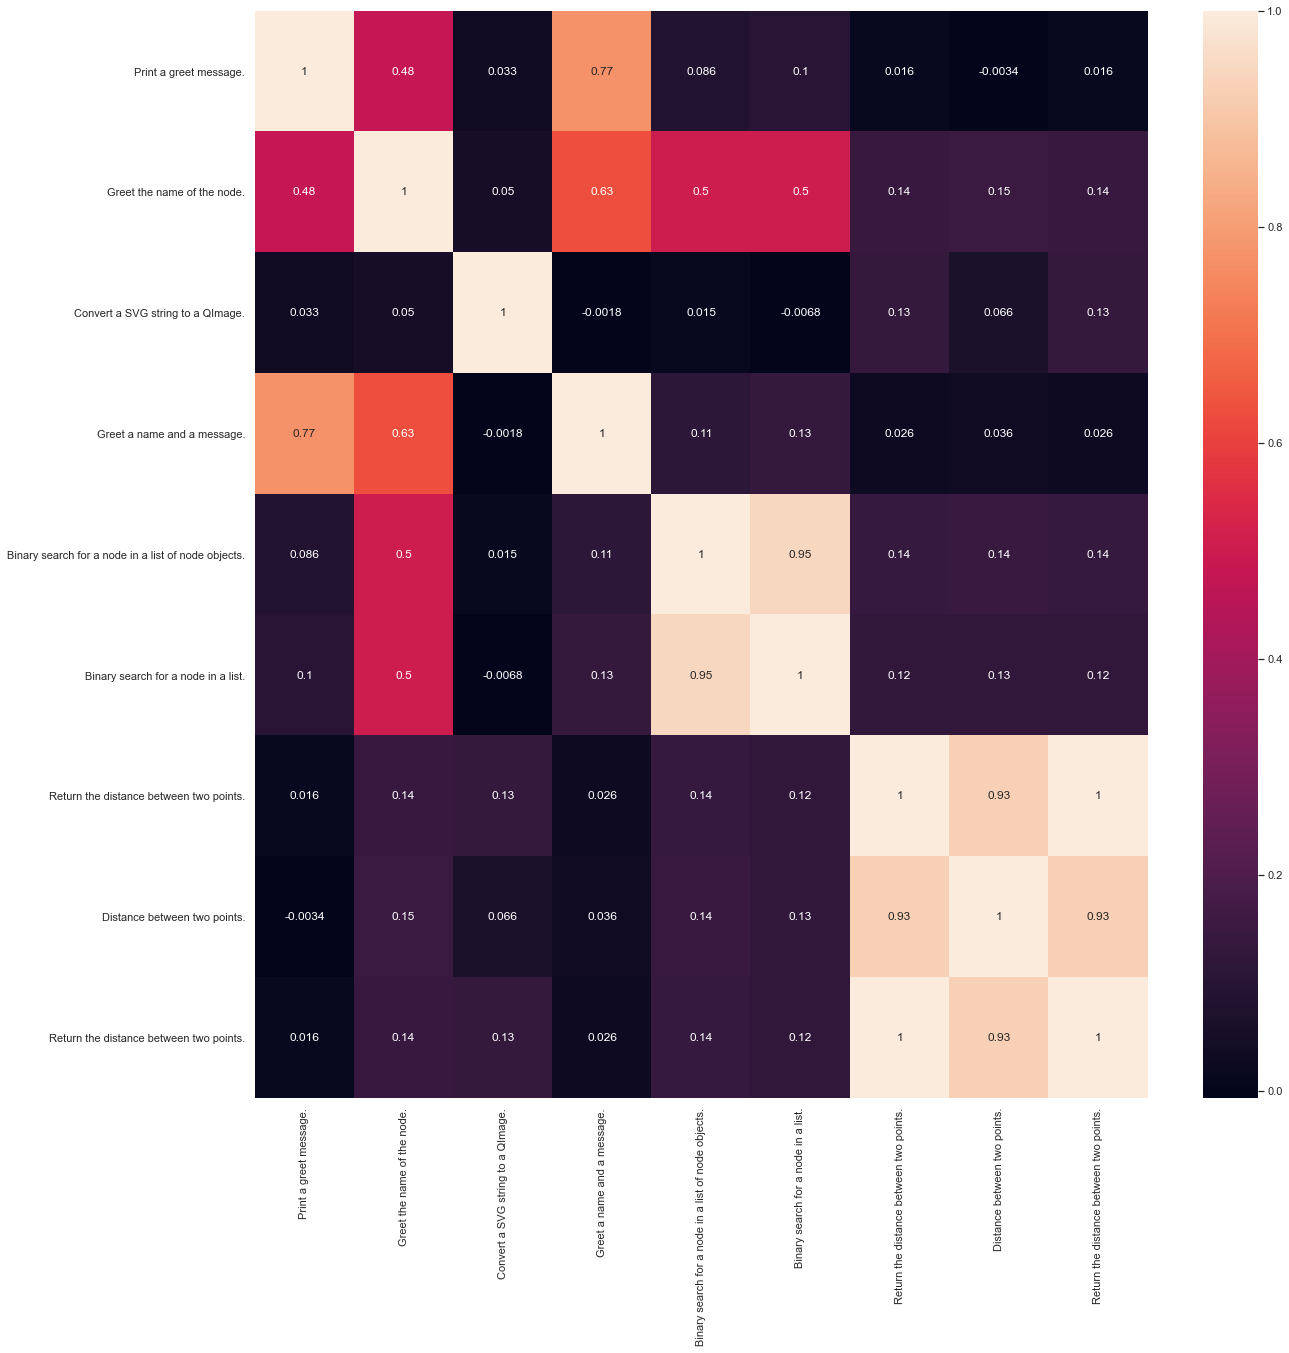

In [11]:
sims = cosine_sims(embeddings)
df = pd.DataFrame(sims, index=summaries, columns=summaries)
df

import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df, annot=True)

In [12]:
sims.min(), sims.mean(), sims.max()

(-0.006768052466213703, 0.3303488703691803, 1.0)

In [13]:
# Ändringar att analysera...
# Verkar det som att semantic similarity kan användas för att upptäcka ändringar
# som hade behövt uppdatera dokumentationen?
# Beror ju dock även på vad som står i dokumentationen...


In [14]:
from loader import load

def load_data(filename, max_code_changes = 10, max_func_history = 2):
    data = load(filename)
    keys = list(data.keys())
    
    size = max_code_changes
    func_history_limit = max_func_history

    code_changes = []
    doc_strings = []

    for key in keys:
        changes = list(data[key])
        c = 0
        for change in data[key]:
            code_changes.append(change[2])
            doc_strings.append(change[1])
            c += 1
            if func_history_limit and c >= func_history_limit:
                break
                
    code_changes = code_changes[:size]
    doc_strings = doc_strings[:size]

    return code_changes, doc_strings




In [15]:
code_changes, doc_strings = load_data('funcdata.pickle', max_code_changes = 40)
print(len(code_changes))

36


In [16]:
[s[:30] for s in doc_strings[:10]]

['Constructs an :class:`Arrow <a',
 'Constructs an :class:`Arrow <a',
 ' Constructs an :class:`Arrow <',
 ' Constructs an :class:`Arrow <',
 ' Constructs an :class:`Arrow <',
 ' Constructs an :class:`Arrow <',
 'Constructs an :class:`Arrow <a',
 'Constructs an :class:`Arrow <a',
 ' Constructs an :class:`Arrow <',
 ' Constructs an :class:`Arrow <']

In [17]:
from tqdm import tqdm
summaries = []
for change in tqdm(code_changes):
    add_summary(change)
#summaries[:3]

100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


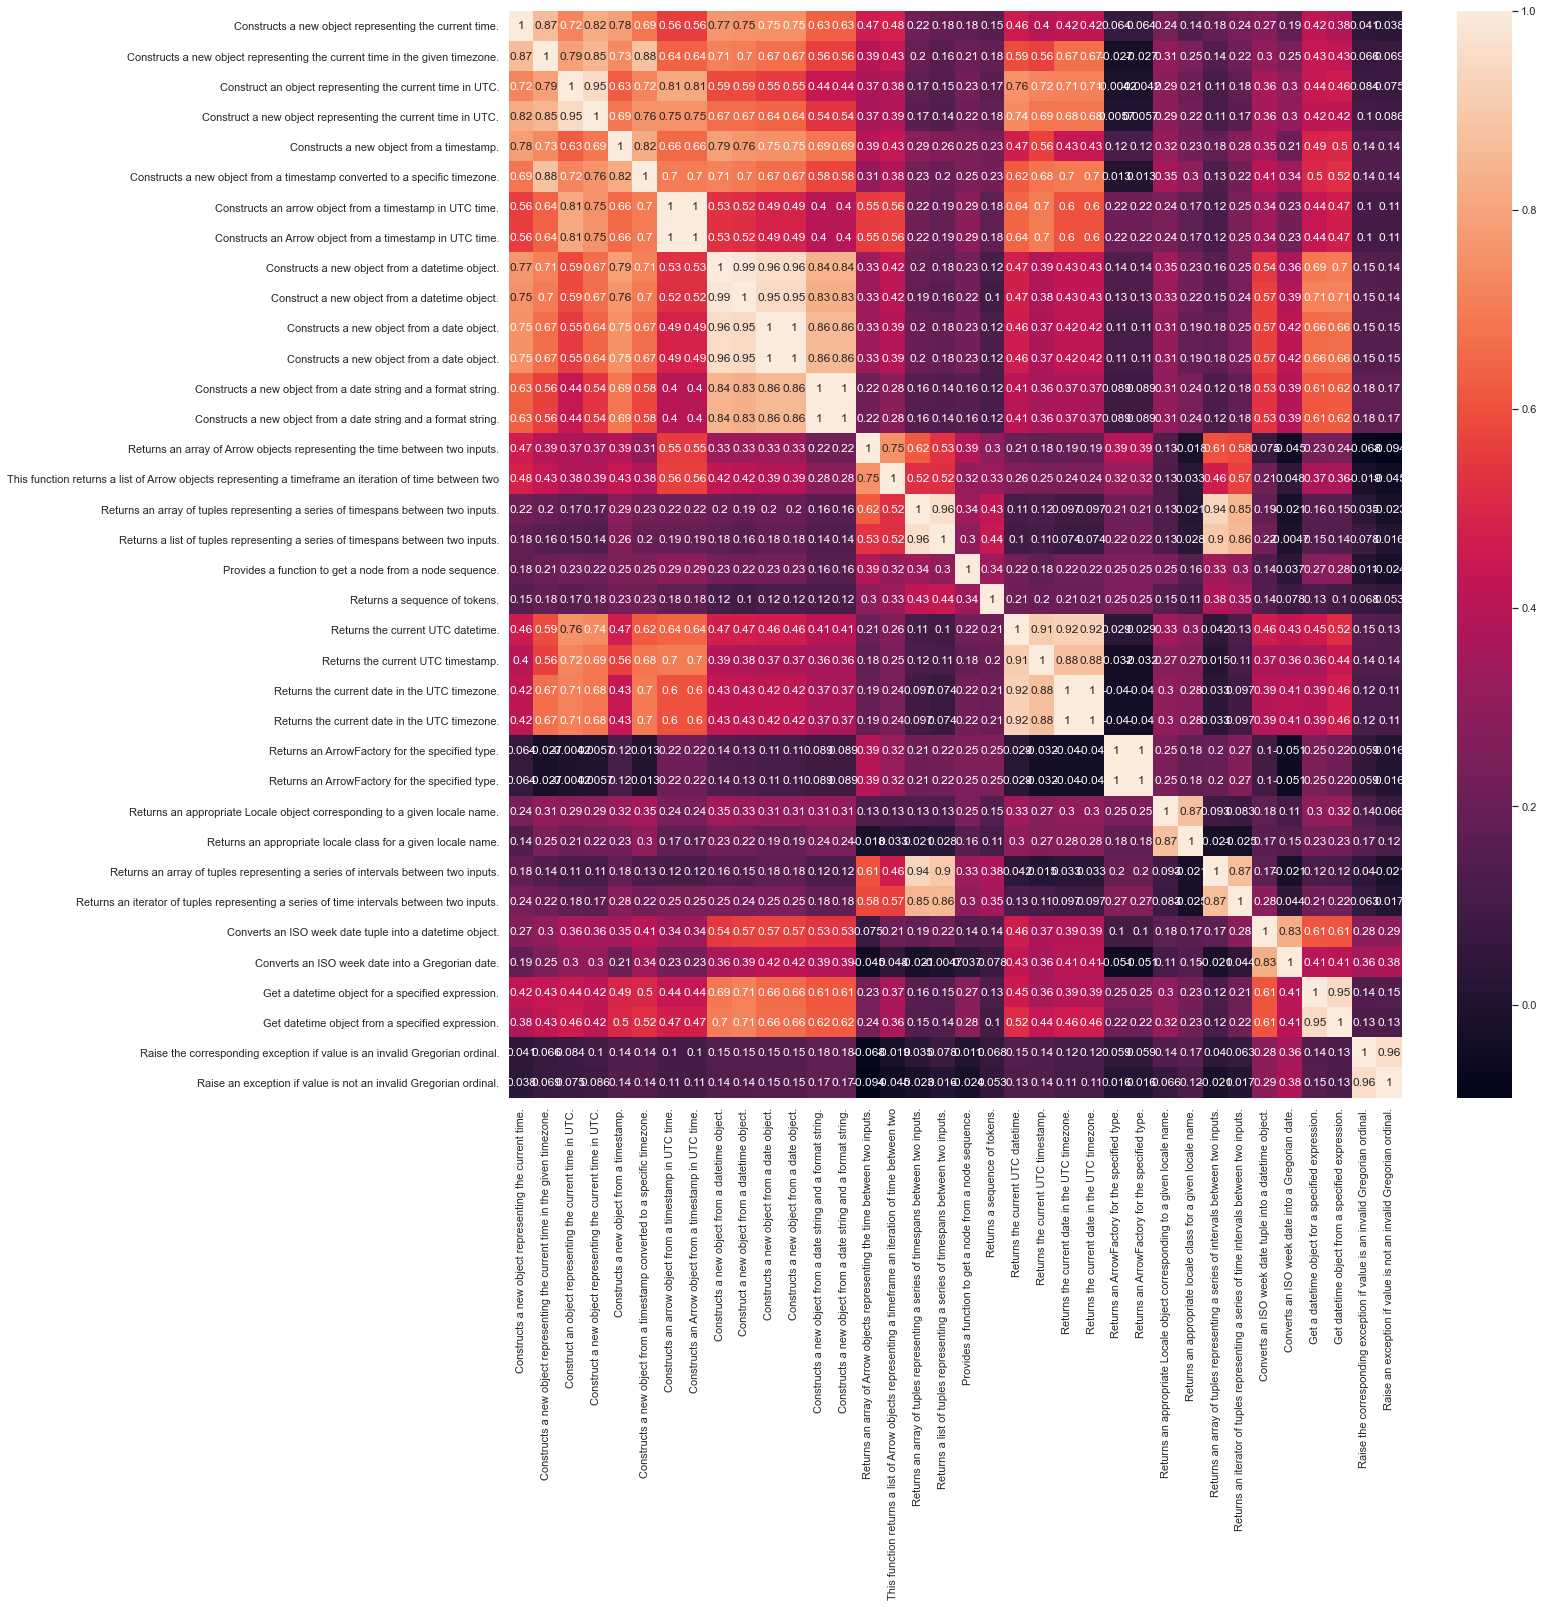

In [18]:
show_sims(embeddings=sbert.encode(summaries), labels=summaries)

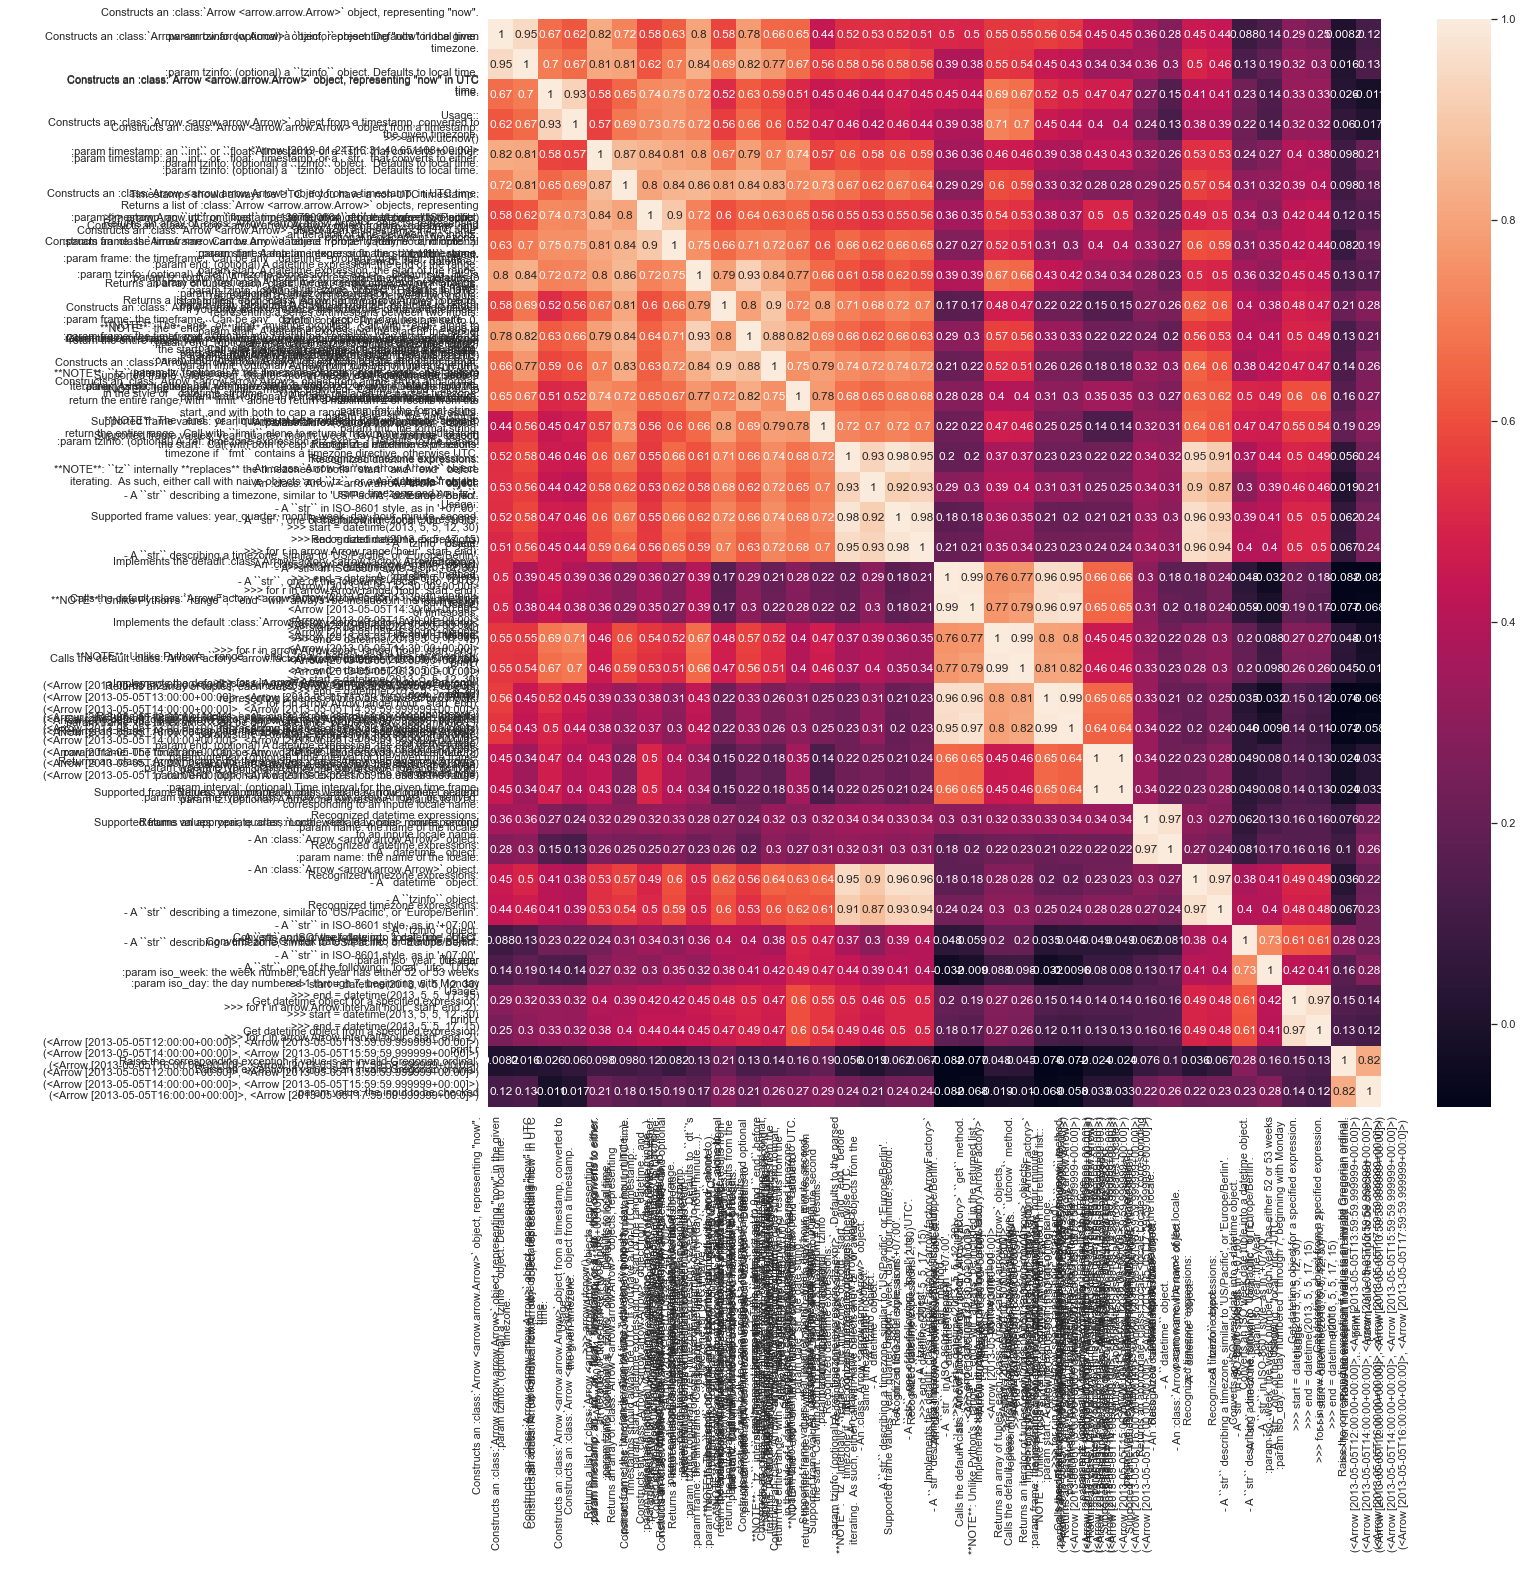

In [19]:
# Prova med doc-strings
show_sims(sbert.encode(doc_strings), labels=doc_strings)

In [20]:
# 9-10, 11-12, 13-14

for i in [9, 11, 13]:
    print('-----------------')
    print(summaries[i])
    print(code_changes[i])
    print('-----------------')


-----------------
Construct a new object from a datetime object.
@classmethod
def fromdatetime(cls, dt, tzinfo=None):
    """ Constructs an :class:`Arrow <arrow.arrow.Arrow>` object from a ``datetime`` and
        optional replacement timezone.

        :param dt: the ``datetime``
        :param tzinfo: (optional) A :ref:`timezone expression <tz-expr>`.  Defaults to ``dt``'s
            timezone, or UTC if naive.

        If you only want to replace the timezone of naive datetimes::

            >>> dt
            datetime.datetime(2013, 5, 5, 0, 0, tzinfo=tzutc())
            >>> arrow.Arrow.fromdatetime(dt, dt.tzinfo or 'US/Pacific')
            <Arrow [2013-05-05T00:00:00+00:00]>

        """
    tzinfo = tzinfo or dt.tzinfo or dateutil_tz.tzutc()
    return cls(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, dt.microsecond, tzinfo)
-----------------
-----------------
Constructs a new object from a date object.
@classmethod
def fromdate(cls, date, tzinfo=None):
    """ Con

In [21]:
signatures = [x.split('\n')[0] for x in code_changes]
for x in zip(signatures, summaries):
    print(x)

('@classmethod', 'Constructs a new object representing the current time.')
('@classmethod', 'Constructs a new object representing the current time in the given timezone.')
('@classmethod', 'Construct an object representing the current time in UTC.')
('@classmethod', 'Construct a new object representing the current time in UTC.')
('@classmethod', 'Constructs a new object from a timestamp.')
('@classmethod', 'Constructs a new object from a timestamp converted to a specific timezone.')
('@classmethod', 'Constructs an arrow object from a timestamp in UTC time.')
('@classmethod', 'Constructs an Arrow object from a timestamp in UTC time.')
('@classmethod', 'Constructs a new object from a datetime object.')
('@classmethod', 'Construct a new object from a datetime object.')
('@classmethod', 'Constructs a new object from a date object.')
('@classmethod', 'Constructs a new object from a date object.')
('@classmethod', 'Constructs a new object from a date string and a format string.')
('@classmet

In [22]:
for (c, d) in list(zip(code_changes, doc_strings))[:6]:
    print(d, c)

Constructs an :class:`Arrow <arrow.arrow.Arrow>` object, representing "now".

        :param tzinfo: (optional) a ``tzinfo`` object. Defaults to local time.

         @classmethod
def now(cls, tzinfo=None):
    """Constructs an :class:`Arrow <arrow.arrow.Arrow>` object, representing "now".

        :param tzinfo: (optional) a ``tzinfo`` object. Defaults to local time.

        """
    utc = datetime.utcnow().replace(tzinfo=dateutil_tz.tzutc())
    dt = utc.astimezone(dateutil_tz.tzlocal() if tzinfo is None else tzinfo)
    return cls(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, dt.microsecond, dt.tzinfo)
Constructs an :class:`Arrow <arrow.arrow.Arrow>` object, representing "now" in the given
        timezone.

        :param tzinfo: (optional) a ``tzinfo`` object. Defaults to local time.

         @classmethod
def now(cls, tzinfo=None):
    """Constructs an :class:`Arrow <arrow.arrow.Arrow>` object, representing "now" in the given
        timezone.

        :param tzinfo: 

In [23]:
x = doc_strings.sort()
x

In [24]:
doc_strings = sorted(doc_strings, key=len)
print(len(doc_strings), len(set(doc_strings)))

36 36


Prova kombinera summeringar

In [35]:
combined = ' '.join(summaries)
print(combined)

Constructs a new object representing the current time. Constructs a new object representing the current time in the given timezone. Construct an object representing the current time in UTC. Construct a new object representing the current time in UTC. Constructs a new object from a timestamp. Constructs a new object from a timestamp converted to a specific timezone. Constructs an arrow object from a timestamp in UTC time. Constructs an Arrow object from a timestamp in UTC time. Constructs a new object from a datetime object. Construct a new object from a datetime object. Constructs a new object from a date object. Constructs a new object from a date object. Constructs a new object from a date string and a format string. Constructs a new object from a date string and a format string. Returns an array of Arrow objects representing the time between two inputs. This function returns a list of Arrow objects representing a timeframe an iteration of time between two Returns an array of tuples 

In [31]:
from transformers import pipeline

summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [33]:
def summarize(text, min_length=10, max_length=100):
    return summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)

In [38]:
test = summarize(combined)
test

[{'summary_text': ' Constructs a new object representing the current time . Constructs an arrow object from a timestamp converted to a specific timezone . Converts an ISO week date tuples into a datetime object .'}]

In [40]:
print(test[0]['summary_text'])

 Constructs a new object representing the current time . Constructs an arrow object from a timestamp converted to a specific timezone . Converts an ISO week date tuples into a datetime object .
